# COGS 108 Final Project: Financial News - Stock Market Correlation

### Gustavo Carbone
### Alec Flowers
### Yang Liu
### Andy Kong
### Christopher Chen
### Christopher Yoon

## Introduction and Background
### Project Overview
* Introduction, background, overview
    * Introduce the background and goals of the project<br>
* Data Loading and Preprocessing
    * Load raw datasets<br>
    * Perform basic cleaning and filtering<br>
* Data Visualization - what do the stock prices look like?
    * Visualize Stock Prices and Sentiment Analysis<br>
* Data Analysis and Results
    * Statistical Analysis of Correlations<br>
* Privacy/Ethics Considerations
* Conclusion and Discussion
    * Implications of results<br>
    * Possible future projects<br>

***
We want to see how positive/negative keywords in news titles correlate with the stock price of that company.

Our hypothesis would be that a positive sentiment in in news titles would correlate with an increase in stock price, while negative sentiment in the news would correlate with a decrease in stock price. We predict that there will be a strong correlation between the two because we believe that the news encompasses many of the factors surrounding a company that then directly affects investors decisions on whether to purchase or sell.

We first looked at correlations between finance news headlines related to the company and company stock price day by day and limited our analysis to two companies: Amazon and Nike.

Next, we also looked at correlations week by week and increased the length of time that we were running our analysis over by gathering 8,000 instead of 2,000 headlines. 

Finally, we broadened the scope of our project by looking at how more general news headlines correlates with the Dow Jones index.  

## Data Description

### Overview

We pulled our data based on two categories: <br\>
1) Data from 2 private companies (Amazon and Nike)<br\>
2) Data from the Dow Jones Index. 

The goal was to get two different data sets for each. The first data set consists of news about the company/DJI and the date the article was published. Basically these data sets consist of tables with two rows: Data and Headlines. The second data set consists of stock price and the date. We found historical data for each of the companies mentioned above and the Dow Jones Index from Yahoo Finance. For the private companies we pulled data for the last 2 years (6 years for DJI). WE did not have to scrape the data from their website since we were able to download the cvs file.

We ended up with six different tables, two for each company/index(stock price and news headlines).

### Process

We started by importing packages that will help us get/visualize data. The packages we used are pretty much the ones that were taught to us on the assignments. Among the packages we used is BeautifulSoup to be able to scrape the web, Matplotlib and Seaborn for visualization, and Pandas to store our data. 

In [1]:
import sys
# !conda install --yes --prefix {sys.prefix} beautifulsoup4
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
import seaborn as sns
import json
import requests
import bs4
from bs4 import BeautifulSoup
from scipy.stats import pearsonr

We have also used an open source machine learning library to analyze the sentiment of news headlines. This particular API was created by Ellon Musk's OpenAI. It has about 670 MB of trained data and 92% accuracy.
To analyze the sentiment of news headlines containing around 2000 data points, it took about 2 hours to run. For our 6 year Reddit news data, which contains over 70000 data points, it took over 5 hours.

In [ ]:
!git clone https://github.com/openai/generating-reviews-discovering-sentiment.git

In [ ]:
%cd generating-reviews-discovering-sentiment
!pip install tqdm --ignore-installed
!pip install tensorflow==1.2.0 --ignore-installed

When we initially started looking at sentiment analysis we used a few other libraries to do preliminary analysis before we found the open source machine learning library. These first few libraries were TextBlob and a IBM Watson Cloud tone analyzer that only allowed us 2500 analysis a month per user. It also didn't analyze words based on a positive/negative scale but rather classified them as sad or happy etc. 

#### Getting the news headlines

We built a function to scrape data from markets.financialcontent.com. This website contains many financial news that it displayed in a formatt that was easier to scrape than other websites. We scraped all of the news headlines up to a "user-limit". We defined "user-limit" to be equal to 8000 data points but it could have been any other number as specified by the user. The result of the function is a Panda dataframe with two columns: the date when the news article was published and the news headline. 

We used this function to get dates - news headlines pairs for the two private companies we are analyzing, Amazon and Nike. The idea behind this is to analyze the sentiment of the headlines and find the correlation between a positive/negative sentiment to the stock going up/down.

In [2]:
# function to extract new headlines and dates.
# Takes starting URL and a limit of how many entries we want our table to be
# It iterates over it until i has a a list of 'user_limit' entries
# Number of entries can be modified by changing the variable 'limit'
# Returns a Panda data frame caontaining the data scraped

def get_headlines(site, user_limit):
    # Creates empty to list where titles will be added
    df = pd.DataFrame(columns=['Date','Headline'])
    page = requests.get(site)
    soup = BeautifulSoup(page.content, 'html.parser')
    newsRead = 0
    
    while newsRead < user_limit:
        #repeat = False;
        news = soup.find_all("div", {"class": "title"})
        for newsItem in news[1:]:
            df.loc[newsRead] = [newsItem.div.string,newsItem.span.string]
            newsRead += 1

        nextPage = soup.find("div", {"class": "numberedpagenav"}).find("a", {"class": "active"}).find_next_sibling()
        if(nextPage['class'] == "disabled"):
            break
        else:        # Changes the page to parse to the next page
            page = requests.get(nextPage['href']) 
            soup = BeautifulSoup(page.content, 'html.parser')

    return df

In [ ]:
# Calling function getHeadlines() to scrape data from website 

#Getting data about Amazon
site = 'https://markets.financialcontent.com/stocks/quote/news?Limit=500&Symbol=537%3A645156'
df_amzn_news = get_headlines(site, 8000)

#Getting data about Nike
site = 'https://markets.financialcontent.com/stocks/quote/news?Limit=500&Symbol=321%3A957150'
df_nike_news = get_headlines(site, 8000)

##### Important Note: 

Since running the sentiment analyzer with OpenAI takes a very long time, we have already implemented all the steps to get our final conclusions on the final project and saved the results to different json files. We did all of these before writting this final draft and therefore we already have all the data we need saved in their respective json files. 

All of the steps described in this notebook are the actual steps we took. With that being sais, since we already have the data and we do not think it is very convenient to re-run OpenAI because of how long it takes, we will load our data to the data frames instantiated above.

In [4]:
## Amazon_8000_newsSentiment.json and Nike_newsSentiment are the json files containing all of the data that
## we already computed a few weeks ago

df_amzn_news = pd.read_json('Amazon_8000_newsSentiment.json')
df_amzn_news.columns = ['Date', 'Headlines', 'Sentiment']
df_amzn_news.drop(['Sentiment'], axis=1, inplace=True)

df_nike_news = pd.read_json('Nike_8000_newsSentiment.json')
df_nike_news.columns = ['Date', 'Headlines', 'Sentiment']
df_nike_news.drop(['Sentiment'], axis=1, inplace=True)

In [5]:
df_amzn_news[:10]

,Date,Headlines
0,2018-03-17,"Goldilocks, R. I. P. (Part 3)"
1,2018-03-17,Walmart's Grocery Efforts Probably Aren't Enou...
10,2018-03-16,Ranked: The Top 5 Most Amazon-Proof Stores
100,2018-03-14,UPDATE 3-Toys 'R' Us plans to close all U.S. s...
1000,2018-02-20,Prime Members Now Earn 5% Back When Shopping a...
1001,2018-02-19,Fred Hickey: Why A Lifelong Technology Expert ...
1002,2018-02-19,Netflix Fires a Warning Volley
1003,2018-02-19,"Roku, BHP Billiton Lead 4 Stocks In Bullish Ba..."
1004,2018-02-19,Snap Sees Its Reliance on Google and Amazon As...
1005,2018-02-19,Amazon Faces a New Trio of Competitors in Japan


For the Dow Jones Index, we obtained 6 years worth of news from https://www.kaggle.com/aaron7sun/stocknews. We were able to download the csv file. It contains news headlines from Reddit WorldNews Channel and only the top 25 headlines are considered for a single date. The range is from 06/08/2008 to 07/01/2016.

In [6]:
df_reddit_news = pd.read_csv('RedditNews.csv')
df_reddit_news.columns = ['Date', 'Headlines']
df_reddit_news[:10]

,Date,Headlines
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
5,2016-07-01,Brazil: Huge spike in number of police killing...
6,2016-07-01,Austria's highest court annuls presidential el...
7,2016-07-01,"Facebook wins privacy case, can track any Belg..."
8,2016-07-01,Switzerland denies Muslim girls citizenship af...
9,2016-07-01,China kills millions of innocent meditators fo...


#### Getting stock price

For this step we retreived data about the stock values for a company/index to be compared to the sentiment of the news headlines.

We found a few data-sets conatining the stock price for Amazon, Nike, and the values of DJI. This data sets contain values for the respective company ordered by date. They have many columns, some useful and some not so useful. The data sets containm columns with information about opening stock price, closing stock price, and many others.

We pulled these data sets from Yahoo Finance.

In [7]:
df_amzn_stock = pd.read_csv('AMZN2yr.csv')
df_nike_stock = pd.read_csv('NKE2yr.csv')
df_dji_stock = pd.read_csv('DJI6yr.csv')
df_amzn_stock[:10]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-21,548.909973,555.239990,538.580017,553.979980,553.979980,5155700
1,2016-03-22,545.109985,562.760010,545.049988,560.479980,560.479980,4000600
2,2016-03-23,561.000000,572.479980,558.099976,569.630005,569.630005,3983700
3,2016-03-24,567.109985,583.549988,567.080017,582.950012,582.950012,5185500
4,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
5,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4167100
6,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
7,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
8,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400
9,2016-04-04,599.000000,599.500000,590.549988,593.190002,593.190002,2470800


## Data Cleaning / Pre-processing


### Overview

We divided the data cleaning and pre-processing in three steps: <br\>1) Sentiment Analysis of News Headlines <br\>2) Stock Price Data Processing <br\>3) Merging previous two DataFrames

First we tackled the all of the data sets containing the news headlines. Since we scrapped these data sets from the web, the data sets are already clean. We just scrapped the data we thought it was going to be useful for our project, therfore we did not need to do any cleaning. On the other hand, we need to pre-process these data sets.

For the pre-processing of these data sets we used the OpenAI API. We needed to analyze each news article and see if the sentiment of such article was possitive of negative. 

#### Using OpenAI to predict sentiment of news headlines

This is one of the critical steps in our project. We needed to predict accuretly the sentiment on news articles. We used Ellon Musks' OpenAI to do the job. It is trained 670 MB of data and it has a 92% accuracy.

To train the data sets containg Amazon and Nike headlines(about 8000 data points) it took over 2 hours ro run and for the data set containing Reddit world news(about 70000+ data points) took over 5 hours.

In [ ]:
## Initializing the OpenAI model
from encoder import Model
model = Model()

In [ ]:
## Transforming and feeding our data into the model to get the sentiment for all three companies
## DO NOT RUN!!! Takes a very long time(Over 9  hrs total!!). It has already been run and data is already stored in their respective
## json files

# Predicting sentiment for Amazon headlines
text_features = model.transform(df_amz_news['Headlines'].sort_index())
sent = text_features[:, 2388]
df_amz_news['Sentiment'] = sent
df_amz_news.to_json('../Amazon_8000_newsSentiment.json')

# Predicting sentiment for Nike headlines
text_features = model.transform(df_nike_news['Headlines'].sort_index())
sent = text_features[:, 2388]
df_nike_news['Sentiment'] = sent
df_nike_news.to_json('../Nike_8000_newsSentiment.json')

# Predicting sentiment for Reddit World News headlines
text_features = model.transform(df_reddit_news['Headlines'].sort_index())
sent = text_features[:, 2388]
df_reddit_news['Sentiment'] = sent
df_reddit_news.to_json('../Reddit_newsSentiment.json')

In [8]:
## Since we already run the OpenAI for all three news data sets, we already have the result stored in their
## respective json files. In this step we will just load them.

## Loading Amazon
df_amzn_news = pd.read_json('Amazon_8000_newsSentiment.json')
df_amzn_news.columns = ['Date', 'Headlines', 'Sentiment']

## Loading Nike
df_nike_news = pd.read_json('Nike_8000_newsSentiment.json')
df_nike_news.columns = ['Date', 'Headlines', 'Sentiment']

## Loading Reddit
df_reddit_news = pd.read_json('Reddit_newsSentiment.json')
df_reddit_news.columns = ['Date', 'Headlines', 'Sentiment']

In [9]:
## 8,000 data points Amazon headlines with sentiment
df_amzn_news[:5]

,Date,Headlines,Sentiment
0,2018-03-17,"Goldilocks, R. I. P. (Part 3)",0.117647
1,2018-03-17,Walmart's Grocery Efforts Probably Aren't Enou...,-0.200662
10,2018-03-16,Ranked: The Top 5 Most Amazon-Proof Stores,-0.007905
100,2018-03-14,UPDATE 3-Toys 'R' Us plans to close all U.S. s...,-0.235217
1000,2018-02-20,Prime Members Now Earn 5% Back When Shopping a...,-0.078292


In [10]:
## 8,000 data points Nike headlines with sentiment
df_nike_news[:5]

,Date,Headlines,Sentiment
10,2018-03-19,The Business Behind the NCAA's Money-Making Ma...,-0.366548
100,2018-02-23,3 Stocks Billionaire Bill Ackman is Buying and...,0.296745
1000,2017-08-10,BRIEF-Kohl's conf call- Q2 inventory per store...,0.198451
1001,2017-08-10,September 29th Options Now Available For Nike ...,-0.417998
1002,2017-08-10,Nike Inc -Cl B Crosses Below its 10-day MA (NKE),0.067618


In [11]:
## 70,000+ data points Reddit headlines with sentiment
df_reddit_news[0:5]

,Date,Headlines,Sentiment
0,2016-07-01,A 117-year-old woman in Mexico City finally re...,0.294050
1,2016-07-01,IMF chief backs Athens as permanent Olympic host,0.193639
10,2016-07-01,France Cracks Down on Factory Farms - A viral ...,-0.263257
100,2016-06-27,Barclays and RBS shares suspended from trading...,-0.059199
1000,2016-05-22,Oil company records from 1960s reveal patents ...,0.155997


#### Dropping columns and creating weekly tables

In this step of our data cleaning process we dropped unnecessary columns and we also created new data frames that contain weekly data instead of daily data.

First, let's drop unnecessary columns and add more useful columns. This time we worked on the tables we got from Yahoo Finance, they included many columns from which some where not very useful for our purposes. This how the original tables look:

In [12]:
df_amzn_stock[0:5]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-21,548.909973,555.239990,538.580017,553.979980,553.979980,5155700
1,2016-03-22,545.109985,562.760010,545.049988,560.479980,560.479980,4000600
2,2016-03-23,561.000000,572.479980,558.099976,569.630005,569.630005,3983700
3,2016-03-24,567.109985,583.549988,567.080017,582.950012,582.950012,5185500
4,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500


From all of these columns we conlcuded that we did not need 'Adj Close' and the 'Volume' column. We just need to see if the stock went up or down in a particular day, therfore these two columns would not be necessary. On the other hand, we added two columns: 'Daily Avg' and 'Daily Change'. The point of our project is find the correlation between the stock price daily change (either down or up) and the sentiment of news headlines for that particular date.

In [13]:
## Modifying Amazon stock data set

#Drop unimportant columns
df_amzn_stock = df_amzn_stock.drop(['Adj Close','Volume'],1)

#Add new columns named Daily Avg that averages the high and low of that day. 
df_amzn_stock['Daily Avg'] = df_amzn_stock[['High','Low']].mean(axis=1)
df_amzn_stock['Daily Change']= df_amzn_stock['Close'].diff()

#Change Date column to date that can be read by matplotlib and pandas
df_amzn_stock['Date'] = pd.to_datetime(df_amzn_stock['Date'])

## Modifying Nike stock data set
df_nike_stock = df_nike_stock.drop(['Adj Close','Volume'],1)
df_nike_stock['Daily Avg'] = df_nike_stock[['High','Low']].mean(axis=1)
df_nike_stock['Daily Change']= df_nike_stock['Close'].diff()
df_nike_stock['Date'] = pd.to_datetime(df_nike_stock['Date'])

## Modifying DJI stock data set
df_dji_stock = df_dji_stock.drop(['Adj Close','Volume'],1)
df_dji_stock['Daily Avg'] = df_dji_stock[['High','Low']].mean(axis=1)
df_dji_stock['Daily Change']= df_dji_stock['Close'].diff()
df_dji_stock['Date'] = pd.to_datetime(df_dji_stock['Date'])

In [14]:
df_amzn_stock[0:5]

,Date,Open,High,Low,Close,Daily Avg,Daily Change
0,2016-03-21,548.909973,555.239990,538.580017,553.979980,546.910004,NaN
1,2016-03-22,545.109985,562.760010,545.049988,560.479980,553.904999,6.500000
2,2016-03-23,561.000000,572.479980,558.099976,569.630005,565.289978,9.150025
3,2016-03-24,567.109985,583.549988,567.080017,582.950012,575.315002,13.320007
4,2016-03-28,584.400024,584.750000,575.559998,579.869995,580.154999,-3.080017


During our analysis of the data we noted that there was little correlation with the stock prices and the headlines if we analyzed the data in a daily basis. We decided to also analyze data by week. 

We wrote a few functions to get our daily data and transform it into weekly data. This way we might find a better correlation and prediction of the stock market by having more data points. We believe that one of the main issues of analyzing the data by day is that there are not many news articles to predict the stock accuretly.

We calculated the weekly average, the weekly change average, and the total weekly change. We did this by taking the opening value on a Mondays and then the closing value on Fridays.

These are the functions we defined to bundle our data by week and the resulting tables.

In [15]:
# input: pandas dataframe that stores csv
def weekNum(t):
    if t.month == 12 and t.week == 1:
        return t.week + (t.year + 1) * 100
    elif t.month == 1 and t.week == 53:
        return 1 + t.year*100
    else:
        return t.week + t.year * 100
    
def weeklyData(df):
    data = pd.DataFrame()
    
    df['Timestamp'] = pd.to_datetime(df['Date']).apply(weekNum)
    df['WeeklyAvg'] = df['Close']
    df['WeeklyChangeAvg'] = df['Close'].diff()
    data['WeeklyChangeTotal'] = df[1:].groupby(df.Timestamp).sum()['WeeklyChangeAvg']
    data[['WeeklyAvg', 'WeeklyChangeAvg']] = df.groupby(df.Timestamp).mean()[['WeeklyAvg','WeeklyChangeAvg']]
    
    return data

In [16]:
## Creating tables with weekly values for Amzon, Nike, and DJI
df_amzn_stock_weekly = weeklyData(df_amzn_stock)
df_nike_stock_weekly = weeklyData(df_nike_stock)
df_dji_stock_weekly = weeklyData(df_dji_stock)

df_amzn_stock_weekly[0:5]

,WeeklyChangeTotal,WeeklyAvg,WeeklyChangeAvg
Timestamp,,,
201612,28.970032,566.759994,9.656677
201613,15.549988,592.911999,3.109998
201614,-3.900024,593.488001,-0.780005
201615,31.290039,612.112000,6.258008
201616,-5.390015,629.547998,-1.078003


We also compacted our daily data for our news tables into weekly tables. Same reason as why we did it for the stock tables. More accuracy. Below is the code we use to create these new data frames.

In [62]:
## Instantiating temporary table for Amazon
df_amzn_news_tmp = pd.read_json('Amazon_8000_newsSentiment.json')
df_amzn_news_tmp.columns = ['Date', 'Headlines', 'Sentiment']

## Instantiating temporary table for Nike
df_nike_news_tmp = pd.read_json('Nike_8000_newsSentiment.json')
df_nike_news_tmp.columns = ['Date', 'Headlines', 'Sentiment']

## Instantiating temporary table for Reddit
df_reddit_news_tmp = pd.read_json('Reddit_newsSentiment.json')
df_reddit_news_tmp.columns = ['Date', 'Headlines', 'Sentiment']

In [63]:
## Amazon weekly news ##
# Convert the date data to timeStamp data
df_amzn_news_tmp['WeekNum'] = pd.to_datetime(df_amzn_news_tmp['Date'])

# Assign weeknum to each date: (e.g. the first week of 2016 -> 201601)
df_amzn_news_tmp['WeekNum'] = df_amzn_news_tmp['WeekNum'].apply(weekNum)

# Create a weekly data frame and column for the sum of numeric sentiment of the week (for later analysis)
df_amzn_news_weekly = df_amzn_news_tmp.groupby(df_amzn_news_tmp['WeekNum']).sum()

# Create a column for the mean of numeric sentiment of the week (for later analysis)
df_amzn_news_weekly['Sentiment_Avg'] = df_amzn_news_tmp.groupby(df_amzn_news_tmp['WeekNum']).mean()

In [64]:
## Performing the same steps executed above to create weekly data frames for Nike and Reddit

## Nike ##
df_nike_news_tmp['WeekNum'] = pd.to_datetime(df_nike_news_tmp['Date'])
df_nike_news_tmp['WeekNum'] = df_nike_news_tmp['WeekNum'].apply(weekNum)
df_nike_news_weekly = df_nike_news_tmp.groupby(df_nike_news_tmp['WeekNum']).sum()
df_nike_news_weekly['Sentiment_Avg'] = df_nike_news_tmp.groupby(df_nike_news_tmp['WeekNum']).mean()

# Reddit ##
df_reddit_news_tmp['WeekNum'] = pd.to_datetime(df_reddit_news_tmp['Date'])
df_reddit_news_tmp['WeekNum'] = df_reddit_news_tmp['WeekNum'].apply(weekNum)
df_reddit_news_weekly = df_reddit_news_tmp.groupby(df_reddit_news_tmp['WeekNum']).sum()
df_reddit_news_weekly['Sentiment_Avg'] = df_reddit_news_tmp.groupby(df_reddit_news_tmp['WeekNum']).mean()

In [65]:
df_amzn_news_weekly[0:5]

,Sentiment,Sentiment_Avg
WeekNum,,
201732,3.299143,0.033665
201733,8.918713,0.037007
201734,13.436643,0.054620
201735,1.536610,0.007388
201736,3.286108,0.019444


In [66]:
df_nike_news_weekly[0:5]

,Sentiment,Sentiment_Avg
WeekNum,,
201107,0.174054,0.174054
201108,0.278228,0.139114
201109,0.144276,0.028855
201110,0.113238,0.056619
201111,0.420170,0.019099


In [67]:
df_reddit_news_weekly[0:5]

,Sentiment,Sentiment_Avg
WeekNum,,
200823,1.346464,0.053859
200824,8.829302,0.050453
200825,6.847349,0.039128
200826,6.975746,0.039861
200827,8.627191,0.049298


#### Merging News Headlines and Stock prices

On this final step of our data cleaning process, we merged the weekly news and stock prices into one big table for all three of the companies we are analyzing. By performing this step, we concluded that it would be easier and more clear to have a table containing all of the data for the visualization step.

In [68]:
## Merging Amazon tables ##

# combine two sets of data into one dataframe named "dataNeeded"
df_amzn_stock_weekly['WeekNum'] = df_amzn_stock_weekly.index
df_amzn_merged = (df_amzn_stock_weekly.join(df_amzn_news_weekly))
df_amzn_merged.dropna(inplace=True)

# Create a column for the change of weekly's sentiment (for later analysis)
df_amzn_merged['Sentiment_Change'] = df_amzn_merged['Sentiment'].diff()

In [69]:
## Mergin Nike Tables ##

# combine two sets of data into one dataframe named "dataNeeded"
df_nike_stock_weekly['WeekNum'] = df_nike_stock_weekly.index
df_nike_merged = (df_nike_stock_weekly.join(df_nike_news_weekly))
df_nike_merged.dropna(inplace=True)

# Create a column for the change of weekly's sentiment (for later analysis)
df_nike_merged['Sentiment_Change'] = df_nike_merged['Sentiment'].diff()

In [70]:
## Mergin REddit/DJI Tables ##

# combine two sets of data into one dataframe named "dataNeeded"
df_dji_stock_weekly['WeekNum'] = df_dji_stock_weekly.index
df_dji_merged = (df_dji_stock_weekly.join(df_reddit_news_weekly))
df_dji_merged.dropna(inplace=True)

# Create a column for the change of weekly's sentiment (for later analysis)
df_dji_merged['Sentiment_Change'] = df_dji_merged['Sentiment'].diff()

We change the index column of each DataFrame to a Year Week format that allows us to display the data in a better way the increaces readability. 

In [71]:
df_amzn_merged.index = df_amzn_merged.index.map(lambda s: str(s)[:4] + ' Week ' + str(s)[-2:])
df_nike_merged.index = df_nike_merged.index.map(lambda s: str(s)[:4] + ' Week ' + str(s)[-2:])
df_dji_merged.index = df_dji_merged.index.map(lambda s: str(s)[:4] + ' Week ' + str(s)[-2:])

These are the resulting three tables after predicting sentiment, cleaning, and merging news and stock prices:

In [72]:
df_amzn_merged[0:5]

,WeeklyChangeTotal,WeeklyAvg,WeeklyChangeAvg,WeekNum,Sentiment,Sentiment_Avg,Sentiment_Change
Timestamp,,,,,,,
2017 Week 32,-19.590027,977.806006,-3.918005,201732,3.299143,0.033665,NaN
2017 Week 33,-9.520019,972.651990,-1.904004,201733,8.918713,0.037007,5.619570
2017 Week 34,-13.209961,955.180005,-2.641992,201734,13.436643,0.054620,4.517930
2017 Week 35,32.989990,965.304004,6.597998,201735,1.536610,0.007388,-11.900032
2017 Week 36,-12.349976,969.610001,-3.087494,201736,3.286108,0.019444,1.749498


In [73]:
df_nike_merged[0:5]

,WeeklyChangeTotal,WeeklyAvg,WeeklyChangeAvg,WeekNum,Sentiment,Sentiment_Avg,Sentiment_Change
Timestamp,,,,,,,
2016 Week 12,-3.069999,63.427501,-1.023333,201612,3.249425,0.040618,NaN
2016 Week 13,-0.060002,61.586001,-0.012000,201613,1.694339,0.121024,-1.555086
2016 Week 14,-2.170002,59.933999,-0.434000,201614,0.632155,0.035120,-1.062184
2016 Week 15,0.080002,59.008000,0.016000,201615,1.302685,0.059213,0.670530
2016 Week 16,-0.070000,59.652000,-0.014000,201616,2.301991,0.127888,0.999306


In [74]:
df_dji_merged[0:5]

,WeeklyChangeTotal,WeeklyAvg,WeeklyChangeAvg,WeekNum,Sentiment,Sentiment_Avg,Sentiment_Change
Timestamp,,,,,,,
2008 Week 24,27.029296,12220.555859,6.757324,200824,8.829302,0.050453,NaN
2008 Week 25,-464.659179,12072.843945,-92.931836,200825,6.847349,0.039128,-1.981953
2008 Week 26,-496.180664,11652.309961,-99.236133,200826,6.975746,0.039861,0.128397
2008 Week 27,-57.969727,11309.079834,-14.492432,200827,8.627191,0.049298,1.651445
2008 Week 28,-188.000000,11218.633984,-37.600000,200828,3.472297,0.019842,-5.154893


## Data Visualization
Now that we have cleaned and processed our data we are ready to visualize the results to see if we can identify any trends in the data. For Amazon, Nike, and Dow Jones we graphed the change in their stock price, their sentiment analysis and finally combine the two graphs. It was interesting to see that of all the sentiment analysis only Nike had a few points that were negative, otherwise in general it seems that the news titles were either positive or neutrally leaning over a weeks time. 

In [75]:
sns.set_style('darkgrid')
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,10)

Text(0.5,70,'Time (Weekly)')

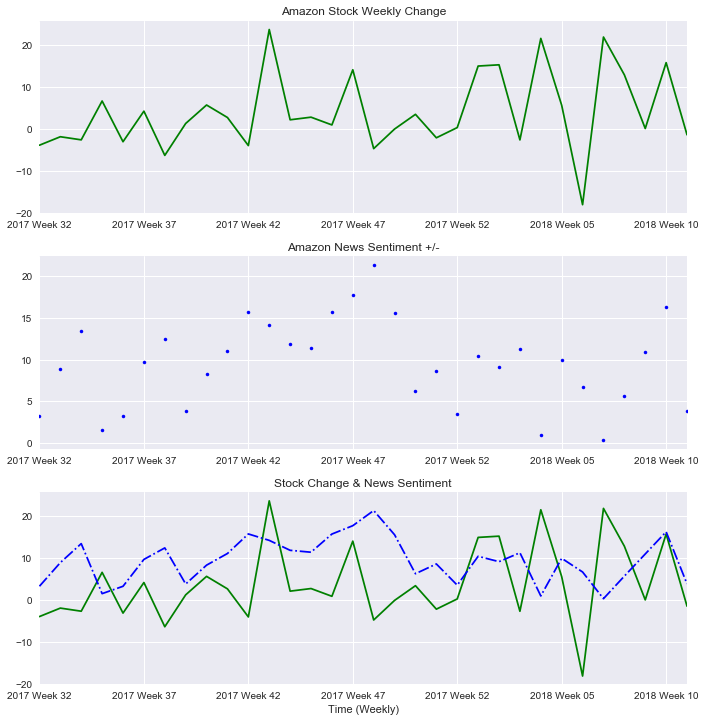

In [104]:
pos_df_amzn = df_amzn_merged['Sentiment'].copy()
neg_df_amzn = df_amzn_merged['Sentiment'].copy()
pos_df_amzn[pos_df_amzn <= 0] = np.nan
neg_df_amzn[neg_df_amzn > 0] = np.nan

fig, axes = plt.subplots(nrows=3)
df_amzn_merged['WeeklyChangeAvg'].plot(ax=axes[0],color='g')

pos_df_amzn.plot(ax=axes[1],style='.',color='b')
neg_df_amzn.plot(ax=axes[1],style='.',color='r')

df_amzn_merged['WeeklyChangeAvg'].plot(ax=axes[2],color='g')
df_amzn_merged['Sentiment'].plot(ax=axes[2],style='-.',color='blue')

fig.tight_layout()
axes[0].set_title('Amazon Stock Weekly Change')
axes[0].set_xlabel('')
axes[1].set_title('Amazon News Sentiment +/-')
axes[1].set_xlabel('')
axes[2].set_title('Stock Change & News Sentiment')
axes[2].set_xlabel('Time (Weekly)')

Text(0.5,70,'Time (Weekly)')

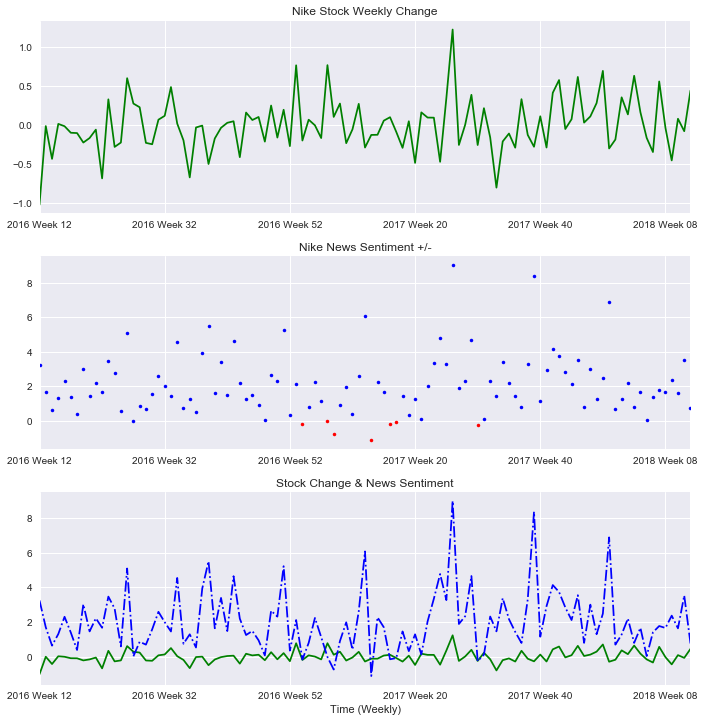

In [105]:
pos_df_nike = df_nike_merged['Sentiment'].copy()
neg_df_nike = df_nike_merged['Sentiment'].copy()
pos_df_nike[pos_df_nike <= 0] = np.nan
neg_df_nike[neg_df_nike > 0] = np.nan

fig, axes = plt.subplots(nrows=3)
df_nike_merged['WeeklyChangeAvg'].plot(ax=axes[0],color='g')

pos_df_nike.plot(ax=axes[1],style='.',color='b')
neg_df_nike.plot(ax=axes[1],style='.',color='r')

df_nike_merged['WeeklyChangeAvg'].plot(ax=axes[2],color='g')
df_nike_merged['Sentiment'].plot(ax=axes[2],style='-.',color='blue')

fig.tight_layout()
axes[0].set_title('Nike Stock Weekly Change')
axes[0].set_xlabel('')
axes[1].set_title('Nike News Sentiment +/-')
axes[1].set_xlabel('')
axes[2].set_title('Stock Change & News Sentiment')
axes[2].set_xlabel('Time (Weekly)')


Text(0.5,70,'Time (Weekly)')

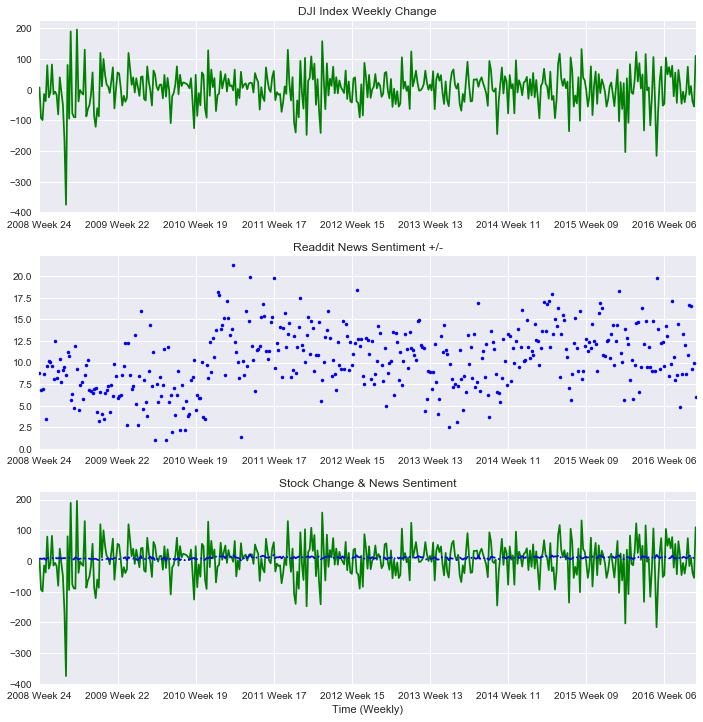

In [111]:
pos_df_dji = df_dji_merged['Sentiment'].copy()
neg_df_dji = df_dji_merged['Sentiment'].copy()
pos_df_dji[pos_df_dji <= 0] = np.nan
neg_df_dji[neg_df_dji > 0] = np.nan

fig, axes = plt.subplots(nrows=3)
df_dji_merged['WeeklyChangeAvg'].plot(ax=axes[0],color='g')

pos_df_dji.plot(ax=axes[1],style='.',color='b')
neg_df_dji.plot(ax=axes[1],style='.',color='r')

df_dji_merged['WeeklyChangeAvg'].plot(ax=axes[2],color='g')
df_dji_merged['Sentiment'].plot(ax=axes[2],style='-.',color='blue')

fig.tight_layout()
axes[0].set_title('DJI Index Weekly Change')
axes[0].set_xlabel('')
axes[1].set_title('Reddit News Sentiment +/-')
axes[1].set_xlabel('')
axes[2].set_title('Stock Change & News Sentiment')
axes[2].set_xlabel('Time (Weekly)')

## Data Analysis and Results

To find meaningful correlations, we used pearsonr module from scipy.stats and looked at p-values and correlation value of resonably amount of possible data pairs. For example, (WeeklyChangeAvg vs. Sentiment of the same week), (WeeklyChangeTotal vs. Sentiment_Change from last week), or (WeeklyAvg from last week vs. Sentiment of this week), and so on. The following displays results that are most meaningful result with the smallest p value we reasonably can find and their correlations. Interestingly it was the WeeklyChangeAvg vs. the Sentiment Change that gave us the best results for all 3 companies. 

                    Amazon        Nike        DJI
    Correlation:    0.31          0.17        0.07
    P value:        0.098         0.089       0.139

When reading this table it shows that the Sentiment Change of the headlines correlated with the stock prices of Amazon with a moderately positive relationship while Nike and DJI at a smaller yet still positive relationship. The P-Vale tells us if the Correlation that we see is significant at all. If we use an alpha = .1 (larger end of alphas) then we can conclude that both Amazon and Nike have a significant, albeit, small positive correlation with their news headlines. DJI unfortunately doesn't show anything that is statisticaly significant. 

Amazon: 
Correlation between Last week's WeeklyChangeTotal and Sentiment_Change
Correlation value =  0.30821729971
P value =  0.0975063781089


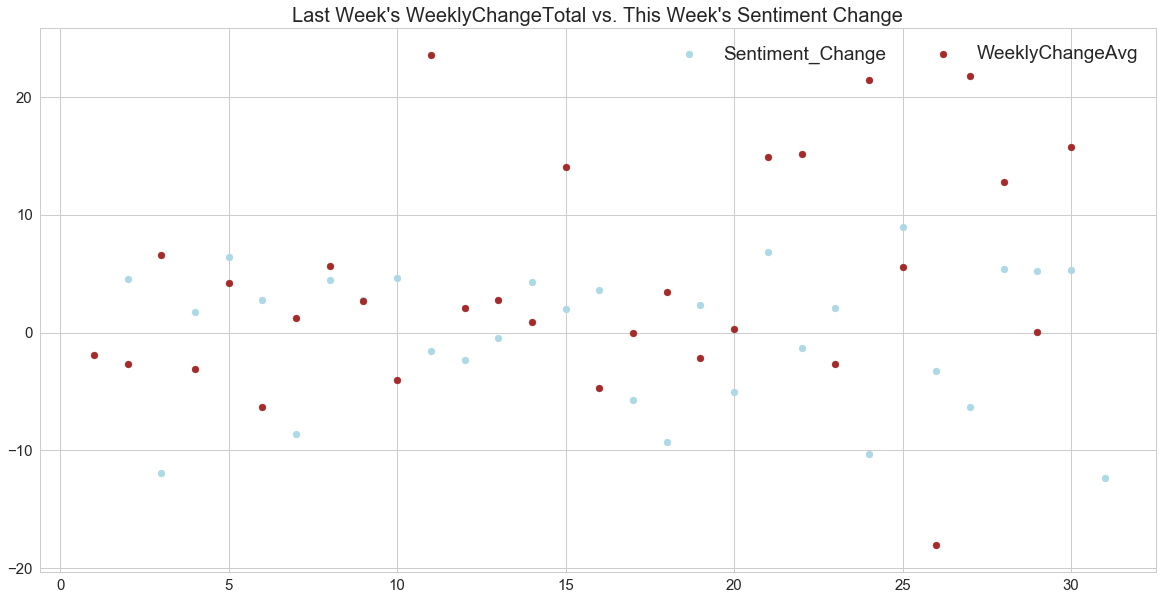

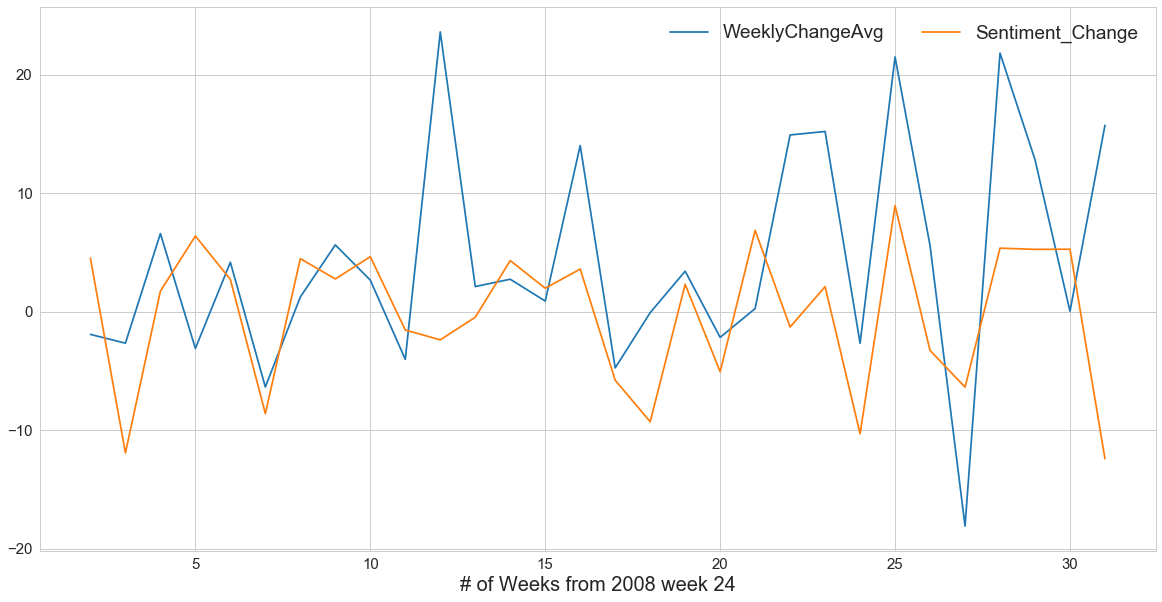

In [113]:
# Representative Analysis for Amazon
print("Amazon: ")
print("Correlation between Last week's WeeklyChangeTotal and Sentiment_Change")
stat, pval = pearsonr(df_amzn_merged['WeeklyChangeTotal'][1:-1],df_amzn_merged['Sentiment_Change'][2:])
print("Correlation value = ", stat)
print('P value = ', pval)

# This indicates
# "Having an increase of stock price in the last week"
# is positively correlated (0.31) to 
# "having more satisfying headlines this week"

df_amzn_merged.index = range(len(df_amzn_merged)) # make 201732 the week 1, so the horizontal data is continuous

# Scatter plot
sns.set_style('whitegrid')
fig = plt.figure(1)
plt.figure(figsize=(20,10))
plt.scatter(df_amzn_merged.index[1:-1]+1,df_amzn_merged['Sentiment_Change'][2:], c='lightblue', label="Sentiment_Change")
plt.scatter(df_amzn_merged.index[1:-1],df_amzn_merged['WeeklyChangeAvg'][1:-1], c='brown', label="WeeklyChangeAvg")
plt.title("Last Week's WeeklyChangeTotal vs. This Week's Sentiment Change", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='best',prop={'size': 19});
# line graph
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(df_amzn_merged.index[1:-1]+1,df_amzn_merged['WeeklyChangeAvg'][1:-1]) 
ax.plot(df_amzn_merged.index[2:],df_amzn_merged['Sentiment_Change'][2:]) 
plt.xlabel('# of Weeks from 2008 week 24', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='best',prop={'size': 19});

Nike: 
Correlation between WeeklyChangeTotal and Sentiment_Change (same week)
Correlation value =  0.16757998681
P value =  0.0890596712428


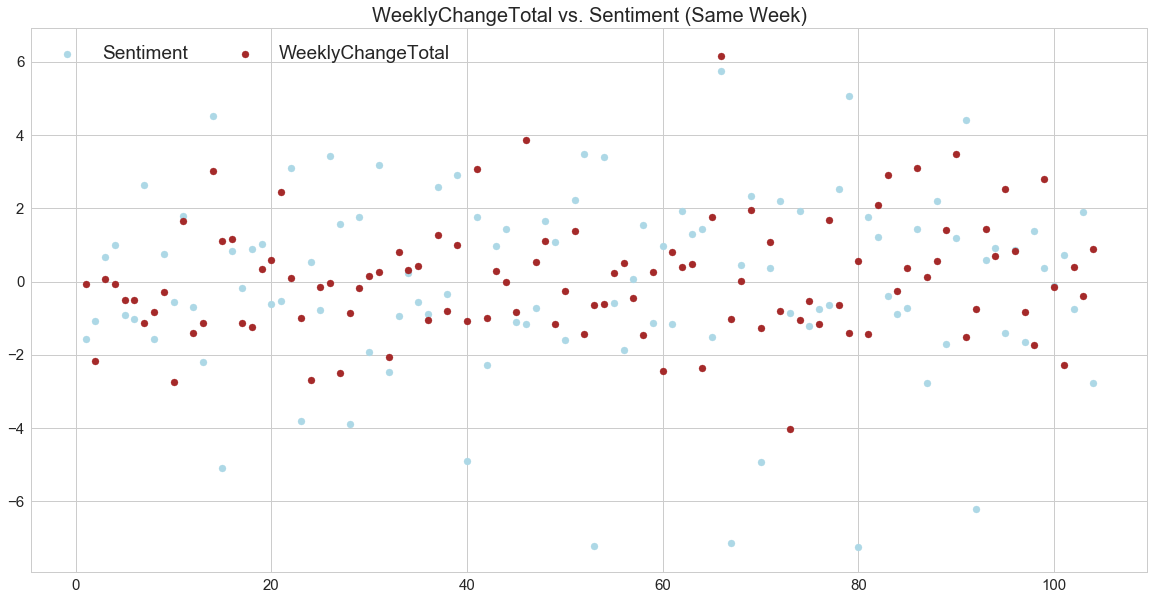

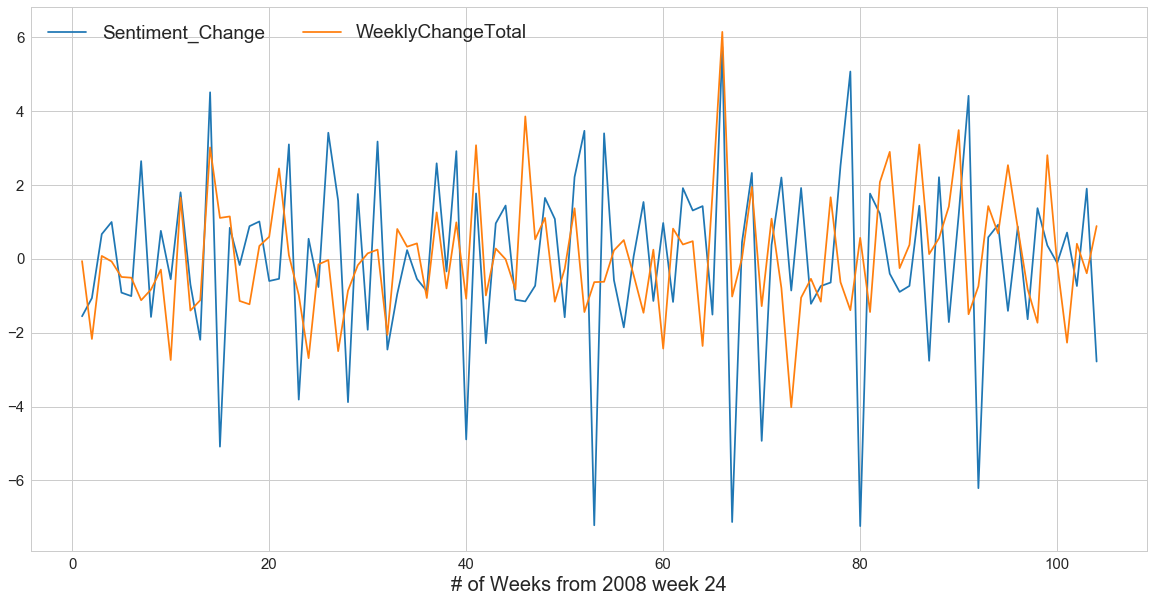

In [114]:
# Representative Analysis for Nike
print("Nike: ")
print("Correlation between WeeklyChangeTotal and Sentiment_Change (same week)")
stat, pval = pearsonr(df_nike_merged['WeeklyChangeTotal'][1:],df_nike_merged['Sentiment_Change'][1:])
print("Correlation value = ", stat)
print('P value = ', pval)

# This indicates
# "Having an increase of stock price "
# is positively correlated (0.17) to 
# "having more satisfying headlines this week"

df_nike_merged.index = range(len(df_nike_merged)) # make 201612 the week 1, so the horizontal data is continuous

# Scatter plot
sns.set_style('whitegrid')
fig = plt.figure(1) 
plt.figure(figsize=(20,10))
plt.scatter(df_nike_merged.index[1:],df_nike_merged['Sentiment_Change'][1:], c='lightblue', label="Sentiment")
plt.scatter(df_nike_merged.index[1:],df_nike_merged['WeeklyChangeTotal'][1:], c='brown', label="WeeklyChangeTotal")
plt.title("WeeklyChangeTotal vs. Sentiment (Same Week)",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='best',prop={'size': 19});
# line graph
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(df_nike_merged.index[1:],df_nike_merged['Sentiment_Change'][1:]) 
ax.plot(df_nike_merged.index[1:],df_nike_merged['WeeklyChangeTotal'][1:])
plt.xlabel('# of Weeks from 2008 week 24', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='best',prop={'size': 19});

DJI: p < 0.15
Correlation between Last week's WeeklyChangeTotal and Sentiment_Change
Correlation value =  0.0724710511838
P value =  0.138616785601


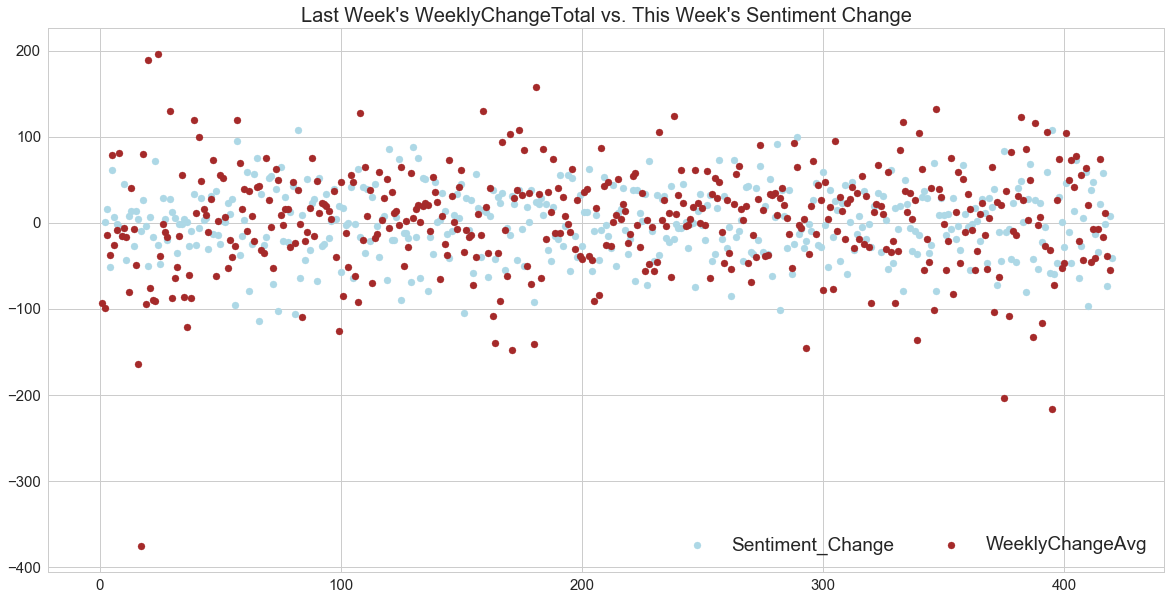

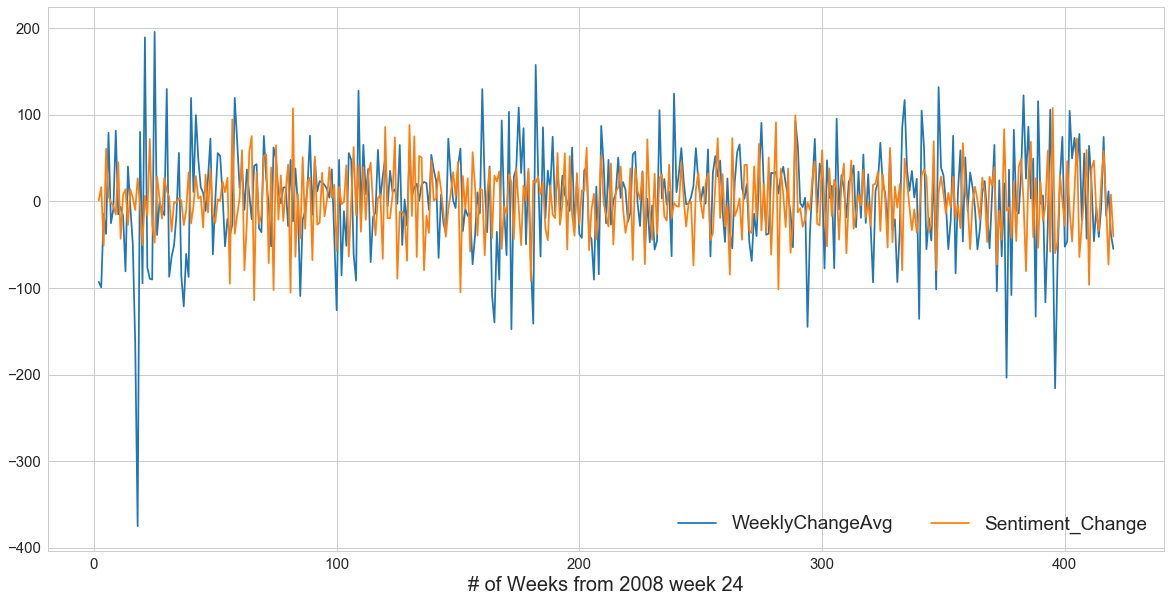

In [115]:
# Representative Analysis for Dow Jones (With p < 0.15)
print("DJI: p < 0.15")
print("Correlation between Last week's WeeklyChangeTotal and Sentiment_Change")
stat, pval = pearsonr(df_dji_merged['WeeklyChangeTotal'][1:-1],df_dji_merged['Sentiment_Change'][2:])
print("Correlation value = ", stat)
print('P value = ', pval)

# This indicates
# "Having an increase of stock price in the last week"
# is positively correlated (0.07) to 
# "having more satisfying headlines this week"

df_dji_merged.index = range(len(df_dji_merged)) # make 200824 the week 1, so the horizontal data is continuous

# Scatter plot
sns.set_style('whitegrid')
fig = plt.figure(1) 
plt.figure(figsize=(20,10))
plt.scatter(df_dji_merged.index[1:-1]+1,df_dji_merged['Sentiment_Change'][2:]*10, c='lightblue', label="Sentiment_Change")
plt.scatter(df_dji_merged.index[1:-1],df_dji_merged['WeeklyChangeAvg'][1:-1], c='brown', label="WeeklyChangeAvg")
plt.title("Last Week's WeeklyChangeTotal vs. This Week's Sentiment Change",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='lower right',prop={'size': 19});
# line graph
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(df_dji_merged.index[1:-1]+1,df_dji_merged['WeeklyChangeAvg'][1:-1]) 
ax.plot(df_dji_merged.index[2:],df_dji_merged['Sentiment_Change'][2:]*10) 
plt.xlabel('# of Weeks from 2008 week 24', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(ncol=2, loc='lower right',prop={'size': 19});

## Privacy/Ethics Considerations

### Privacy

There were very few concerns in our project with privacy since most of the data was publically available and did not contain any sensitive information about users.

#### News Headlines Data

We got our data for the news healines from two sources. The first, for Amazon and Nike, we got it from https://markets.financialcontent.com. Since all the headlines did not contain any sensitive personal information about any user, we did not have to worry about privacy concerns. Our second source, for Reddit news, was https://www.kaggle.com/aaron7sun/stocknews. The data was already cleaned and free of any sensitive information but it is important to point out that the person that gather this data set did indeed have to clean the data. In particular they had to eliminate the user names of Reddit users. This is very important since many users on Reddit may use personal email addresses as usernames or they may use some user name that will be able to identify the person.

#### Stock Price

The data we got for stock prices of Amazon, Nike, and the Dow Jones Index is free of any sensitive information. We got the data from Yahoo Finance and it just contains publicly available data about the stock market.


### Ethics

This is a very important issue, specially with all the turmoil happening now about certain companies unethical methods of getting sensitive information without consent of the individuals in question. 

We made sure all of our data come from publically available, well established sites and only use a limited amount of them solely for the purpose of our academic research. We also made sure not to violate any of the terms of use of all sites we got our data from. 

## Discussion and Conclusion

In our origional analysis we looked at correlations between news headlines and stock price day by day. The sentiment analysis was run on Nike and Amazon financial news articles, however there was a lack of data to create a correlation. Generally, there were two to five articles that actually discussed Nike / Amazon, however this did not mean that these articles were related to their respective companies. Largely, there were articles that discussed about rival companies’ successes or failures. This created a discrepancy for analyzing sentiment of the headlines where a negative sentiment does not actually reflect negativity in our stocks. For example, an article titled \“Stephen Curry to play in Under Armour Low-Tops for First Time\” may output a positive sentiment, but that headline does not relate to Nike. It would be a toss-up as to how this headline would affect Nike’s stocks. Thus, sentiment analysis on daily news articles would leave ambiguous results when correlated with daily stock prices

Our first attempt at finding correlations was mildly unsuccessful so we went back to the drawing board and figured that we would need to aggreagte more data. The best way to do this would be to switch from a day by day analysis to a week by week analysis. We also figured this would smooth out the variability in the stock price data and hopefully leave us with some tangible results. There were some correlation in weekly data which we can attribute to the smoothing of stock price data, having many more articles contributing to the sentiment, and upgrading out sentiment analyzer to "Elon Musk" level.

Both Amazon and Nike had P-values that we determined (using an alpha = .1) was statistically significant. Basically given the news articles we scraped off of the web we were actually to find a small correlation with the stock price. Of course, none of this was groundbreaking as the correlations themselves were small, not to mention if we had chosen an alpha of .05 then these correlations could potentially be deemed as statistically insignificant. 

A turn towards correlating weekly stock prices to a week's worth of news articles yielded a better result. There was correlation in weekly data because of plentiful news headlines to analyze versus one stock price per week.

For Amazon we found that an increase of stock price from a given week X is positively correlated to more satisfying news headlines the week of X + 1 with respect to the previous week.

There was a more interesting result for Nike. We found that an increase of the stock price on a given week X is postive correlated with more satisfying news headlines during the same week X in comparison with the week previous to X. 

We also looked at the Dow Jones Industrial Average (^DJI) index and how it was affected by world news that was provided by Reddit. The Dow Jones Industrial Average index includes 30 large public companies in the United States. It shows how these companies have been trading as one price that is the sum of the 30 prices. Because of the concept of the Dow Jones Industrial, a change in its prices means that there has been a systematic change to its component companies. A systematic change means that there has been a factor that has affected every company in the index. World news would be able to cause a systemmatic change as the news does not relate to any single company. Since Reddit had on average 25 articles per day which aggregated to a week's worth of data, there was enough data for correlation. The analysis of DJI yielded the same results as Amazon, an increase of stock price from a given week X is positively correlated to more satisfying news headlines the following week of X. One diffence to notice of the results of DJI in comparison to Amazon is that the correlation value is very small and the p value is greater than 0.1(for ^DJI).

The correlations found in this project can be used as general notice that a week of positively toned articles do positively affect the stock prices. With that being said, the p values were not satisfactory enough to reject the null hypothesis. With Amazon's, Nike's, and DJI's p values being 0.098, 0.089, and 0.139 respectively. Therefore we can not be certain that a week of positively toned articles do positively affect the stock prices but there exists a correlation in between the two as shown above.

There are many things that can be improved upon in this project. First, we used the best possible sentiment analyzer we could find for free on the internet, however, there is room for improvement as we could have tried to build our own analyzer trained on Finance/World news articles that could prove to be more accurate. Second, it would have been awesome to have been able to build a more robust database of news titles from multiple different sources that we could have done some cleaning on to remove any titles that were irrelevant. Another path to go would be to not just analyze the news title itself, which could be completely misleading (especially to a machine), but to also analyze the entire article. Of course this would be much much more intensive and would require mountains of web scraping. 